# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print(sklearn.__version__)
# assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
#assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

0.19.2
2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [2]:
def plot_image(image):
  plt.imshow(image, cmap='gray', interpolation='nearest')
  plt.axis('off')
  
def plot_color_image(image):
  plt.imshow(image, interpolation='nearest')
  plt.axis('off')

# What is a Convolution

/usr/local/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/usr/local/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/usr/local/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/usr/local/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``im

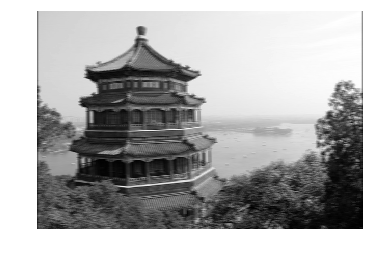

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.axis('off')
plt.show()

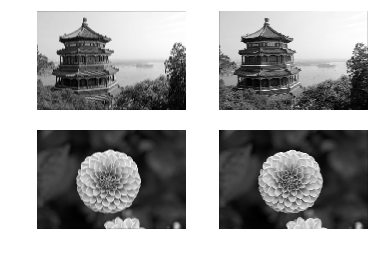

In [4]:
for image_index in (0, 1):
  for feature_map_index in (0, 1):
    plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
    plot_image(outputs[image_index, :, :, feature_map_index])
    
plt.show()

In [5]:
def crop(images):
  return images[150:220, 130:250]

Saving figure china_original


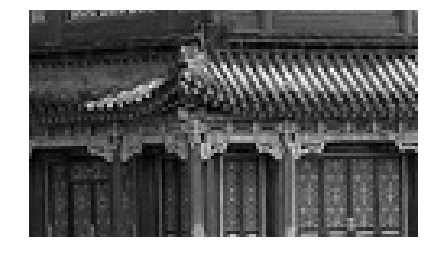

In [6]:
plot_image(crop(images[0, :, :, 0]))
save_fig('china_original', tight_layout=True)
plt.show()

Saving figure china_vertical


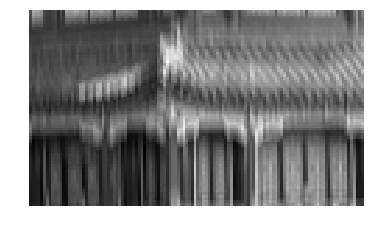

Saving figure china_horizontal


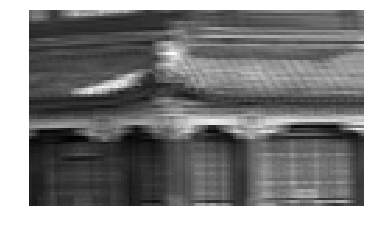

In [7]:
for feature_map_index, filename in enumerate(['china_vertical', 'china_horizontal']):
  plot_image(crop(outputs[0, :, :, feature_map_index]))
  save_fig(filename, tight_layout=False)
  plt.show()

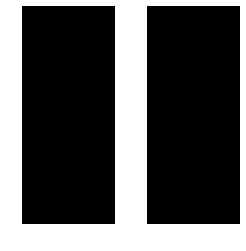

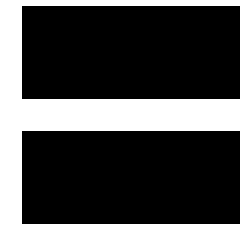

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

In [9]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='SAME', activation='relu')


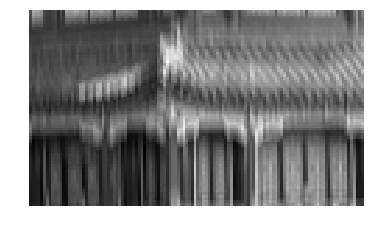

In [10]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

## VALID vs SAME padding

In [11]:
def feature_map_size(input_size, kernel_size, strides=1, padding='SAME'):
  if padding == 'SAME':
    return (input_size - 1) // strides + 1
  else:
    return (input_size - kernel_size) // strides + 1

In [12]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
  fmap_size = feature_map_size(input_size, kernel_size, strides)
  padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
  pad_before = (padded_size - input_size) // 2
  return pad_before, padded_size

In [13]:
def manual_same_padding(images, kernel_size, strides=1):
  if kernel_size == 1:
    return images.astype(np.float32)
  batch_size, height, width, channels = images.shape
  top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
  left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
  padded_shape = [batch_size, padded_height, padded_width, channels]
  padded_images = np.zeros(padded_shape, dtype=np.float32)
  padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
  return padded_images

In [14]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding='VALID')
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding='SAME')

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

conv_same.build(tf.TensorShape(images.shape))
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# Pooling layer

## Max pooling

In [15]:
max_pool = keras.layers.MaxPool2D(pool_size=2)


In [16]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Saving figure china_max_pooling


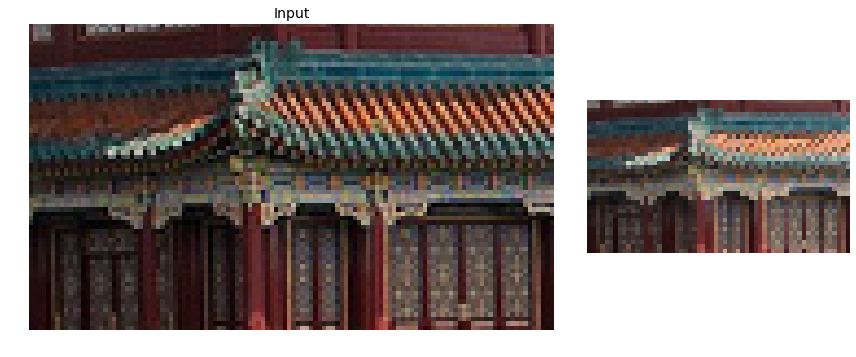

In [17]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis('off')
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(output[0])
ax2.axis('off')
save_fig('china_max_pooling')

## Depth-wise pooling

In [18]:
class DepthMaxPool(keras.layers.Layer):
  def __init__(self, pool_size, strides=None, padding='VALID', **kwargs):
    super().__init__(**kwargs)
    if strides is None:
      strides = pool_size
    self.pool_size = pool_size
    self.strides = strides
    self.padding = padding
  def call(self, inputs):
    return tf.nn.max_pool(inputs, ksize=(1, 1, 1, self.pool_size), strides=(1, 1, 1, self.pool_size), padding=self.padding)

In [19]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding='VALID'))
with tf.device('/cpu:0'):
  depth_output = depth_pool(cropped_images)
depth_output.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 70, 120, 1])

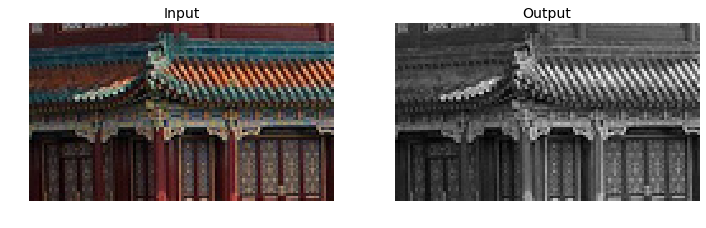

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('Input', fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title('Output', fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis('off')
plt.show()

## Averaging pooling

In [21]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [22]:
output_avg = avg_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



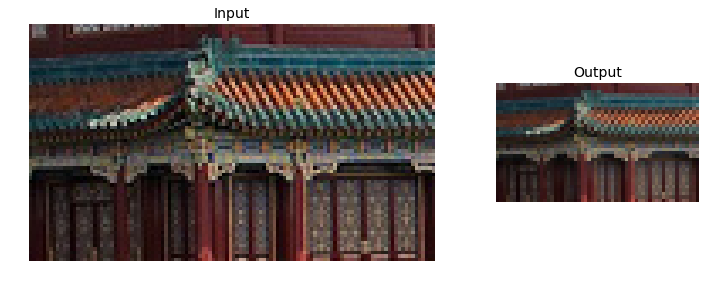

In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis('off')
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Output', fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis('off')
plt.show()

## Global Average Pooling

In [24]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [25]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

# Tackling Fashion MNIST With a CNN

In [26]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [27]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [28]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='SAME')

model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=10, activation='softmax'),
])

In [29]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 37s 677us/sample - loss: 0.7034 - accuracy: 0.7501 - val_loss: 0.3874 - val_accuracy: 0.8588
Epoch 2/10
55000/55000 [==============================] - 35s 636us/sample - loss: 0.4279 - accuracy: 0.8538 - val_loss: 0.3170 - val_accuracy: 0.8882
Epoch 3/10
55000/55000 [==============================] - 35s 641us/sample - loss: 0.3592 - accuracy: 0.8776 - val_loss: 0.3272 - val_accuracy: 0.8780
Epoch 4/10
55000/55000 [==============================] - 35s 637us/sample - loss: 0.3392 - accuracy: 0.8878 - val_loss: 0.2997 - val_accuracy: 0.8934
Epoch 5/10
55000/55000 [==============================] - 35s 638us/sample - loss: 0.3014 - accuracy: 0.8958 - val_loss: 0.2783 - val_accuracy: 0.8976
Epoch 6/10
55000/55000 [==============================] - 35s 635us/sample - loss: 0.2921 - accuracy: 0.9015 - val_loss: 0.2700 - val_accuracy: 0.9010
Epoch 7/10
55000/55000 [=====================

## ResNet-34

In [30]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='SAME', use_bias=False)

class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
      DefaultConv2D(filters, strides=strides),
      keras.layers.BatchNormalization(),
      self.activation,
      DefaultConv2D(filters),
      keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
        DefaultConv2D(filters, kernel_size=1, strides=strides),
        keras.layers.BatchNormalization()
      ]
      
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [31]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='SAME'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Using a Pretrained Model

In [33]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

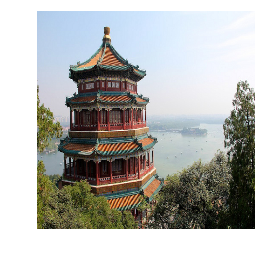

In [34]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


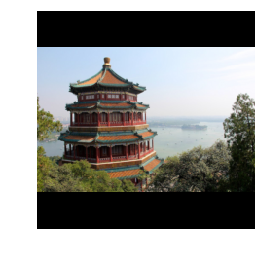

In [35]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

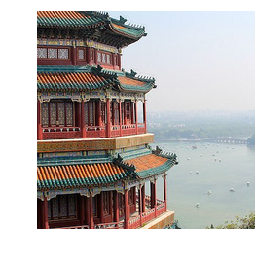

In [36]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

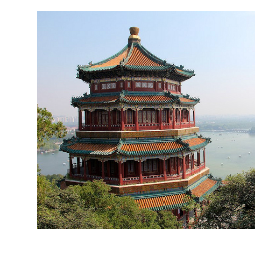

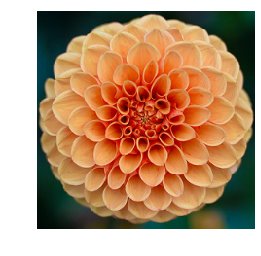

In [37]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [38]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [39]:
Y_proba.shape

(2, 1000)

In [40]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print('Image ${}'.format(image_index))
  for class_id, name, y_proba in top_K[image_index]:
    print('  {} = {:12s} {:.2f}%'.format(class_id, name, y_proba * 100))
  print()

Image $0
  n03877845 = palace       43.39%
  n02825657 = bell_cote    43.08%
  n03781244 = monastery    11.69%

Image $1
  n04522168 = vase         53.97%
  n07930864 = cup          9.52%
  n11939491 = daisy        4.96%



## Pretrained Models for Transfer Learning

In [41]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [42]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [43]:
info.splits['train']

<tfds.core.SplitInfo num_examples=3670>

In [44]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [45]:
n_classes = info.features['label'].num_classes

In [46]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

In [47]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set_raw = tfds.load('tf_flowers', split=test_split, as_supervised=True)
valid_set_raw = tfds.load('tf_flowers', split=valid_split, as_supervised=True)
train_set_raw = tfds.load('tf_flowers', split=train_split, as_supervised=True)

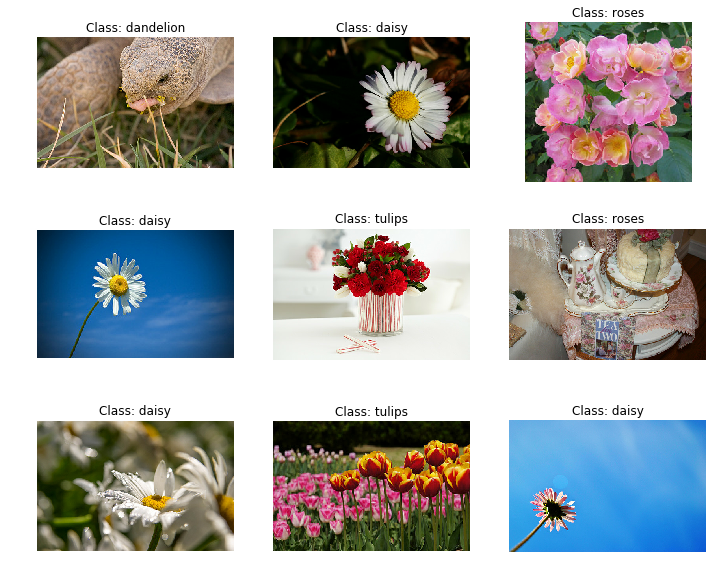

In [48]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title('Class: {}'.format(class_names[label]))
  plt.axis('off')

In [49]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [50]:
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
  return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
  if randomize:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    cropped_image = central_crop(image)
  resized_image = tf.image.resize(cropped_image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [51]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

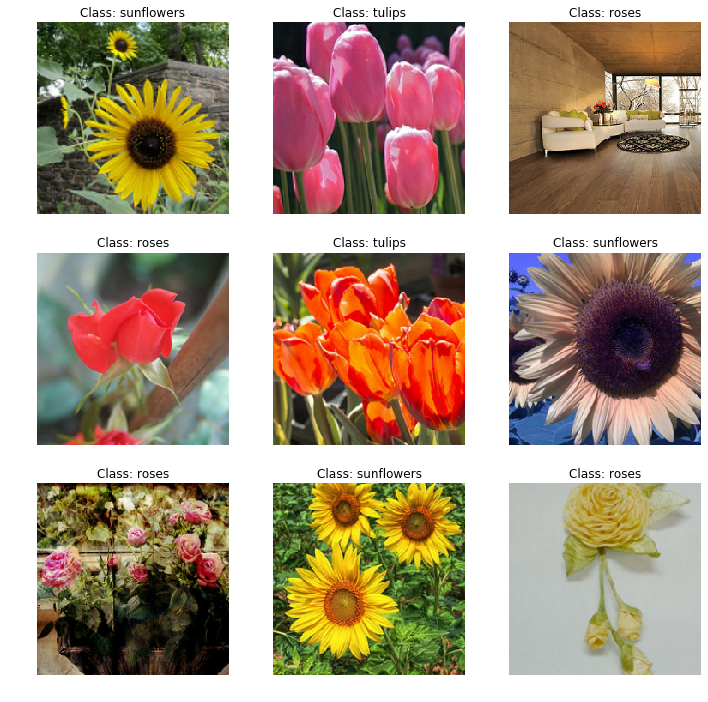

In [52]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
  for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title('Class: {}'.format(class_names[y_batch[index]]))
    plt.axis('off')

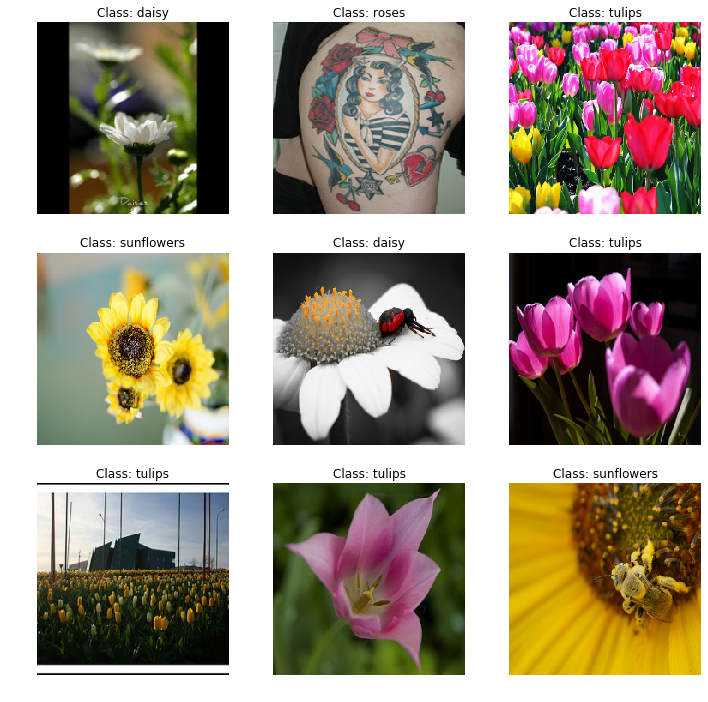

In [53]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
  for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title('Class: {}'.format(class_names[y_batch[index]]))
    plt.axis('off')

In [54]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)


In [55]:
for index, layer in enumerate(base_model.layers):
  print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [56]:
for layer in base_model.layers:
  layer.trainable = False
  
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size), validation_data=valid_set, validation_steps=int(0.15 * dataset_size / batch_size), epochs=5)

Train for 86 steps, validate for 17 steps
Epoch 1/5
86/86 [==============================] - 41s 472ms/step - loss: 0.7681 - accuracy: 0.7529 - val_loss: 1.0048 - val_accuracy: 0.7996
Epoch 2/5
86/86 [==============================] - 35s 409ms/step - loss: 0.4150 - accuracy: 0.8739 - val_loss: 0.9548 - val_accuracy: 0.7776
Epoch 3/5
86/86 [==============================] - 35s 410ms/step - loss: 0.3347 - accuracy: 0.9008 - val_loss: 0.8938 - val_accuracy: 0.7960
Epoch 4/5
86/86 [==============================] - 35s 409ms/step - loss: 0.3014 - accuracy: 0.8968 - val_loss: 1.1430 - val_accuracy: 0.7592
Epoch 5/5
86/86 [==============================] - 35s 409ms/step - loss: 0.2470 - accuracy: 0.9182 - val_loss: 0.8843 - val_accuracy: 0.7868


In [57]:
for layer in base_model.layers:
  layer.trainable = True
  
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, decay=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_set, steps_per_epoch=int(0.75 * dataset_size / batch_size), validation_data=valid_set, validation_steps=int(0.15 * dataset_size / batch_size), epochs=40)

Train for 86 steps, validate for 17 steps
Epoch 1/40
86/86 [==============================] - 120s 1s/step - loss: 0.2646 - accuracy: 0.9077 - val_loss: 0.6477 - val_accuracy: 0.8585
Epoch 2/40
86/86 [==============================] - 111s 1s/step - loss: 0.0997 - accuracy: 0.9680 - val_loss: 0.5138 - val_accuracy: 0.8750
Epoch 3/40
86/86 [==============================] - 111s 1s/step - loss: 0.0596 - accuracy: 0.9804 - val_loss: 0.2244 - val_accuracy: 0.9357
Epoch 4/40
86/86 [==============================] - 111s 1s/step - loss: 0.0432 - accuracy: 0.9855 - val_loss: 0.1924 - val_accuracy: 0.9467
Epoch 5/40
86/86 [==============================] - 111s 1s/step - loss: 0.0209 - accuracy: 0.9949 - val_loss: 0.2082 - val_accuracy: 0.9467
Epoch 6/40
86/86 [==============================] - 111s 1s/step - loss: 0.0241 - accuracy: 0.9938 - val_loss: 0.1978 - val_accuracy: 0.9504
Epoch 7/40
86/86 [==============================] - 111s 1s/step - loss: 0.0172 - accuracy: 0.9953 - val_loss: 0

## Classification and Localization

In [60]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation='softmax')(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[0.8, 0.2], optimizer=optimizer, metrics=['accuracy'])

In [61]:
def add_random_bounding_boxes(images, labels):
  fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
  return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [62]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Train for 5 steps
Epoch 1/2
5/5 [==============================] - 12s 2s/step - loss: 1.3784 - dense_7_loss: 1.6227 - dense_8_loss: 0.4011 - dense_7_accuracy: 0.2125 - dense_8_accuracy: 0.2188
Epoch 2/2
5/5 [==============================] - 6s 1s/step - loss: 1.3079 - dense_7_loss: 1.5541 - dense_8_loss: 0.3232 - dense_7_accuracy: 0.2875 - dense_8_accuracy: 0.2250


### Mean Average Precision (mAP)

In [71]:
def maximum_precisions(precisions):
  return np.flip(np.maximum.accumulate(np.flip(precisions)))

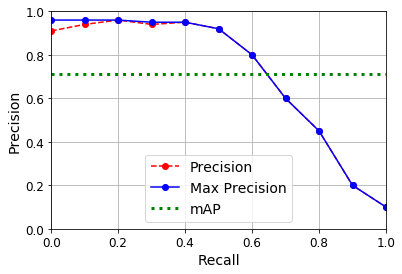

In [72]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, 'ro--', label='Precision')
plt.plot(recalls, max_precisions, 'bo-', label='Max Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot([0, 1], [mAP, mAP], 'g:', linewidth=3, label='mAP')
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc='lower center', fontsize=14)

In [73]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding='VALID')
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

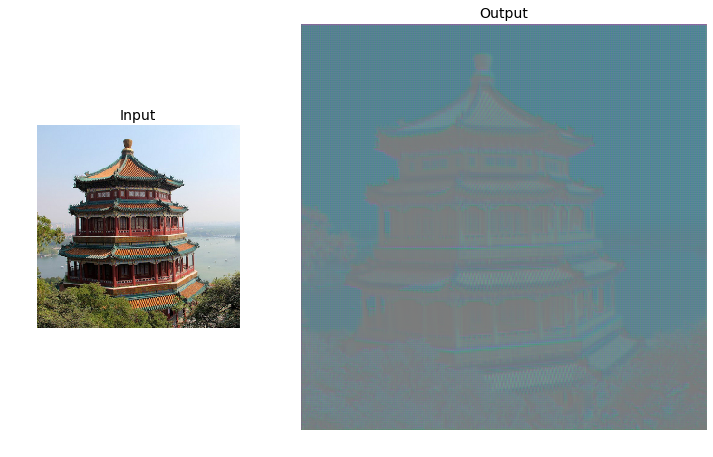

In [74]:
def normalize(X):
  return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize=14)
ax1.imshow(X[0])
ax1.axis('off')
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Output', fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation='bicubic')
ax2.axis('off')
plt.show()